In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/namestxt'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/namestxt/names.txt


In [2]:
with open("/kaggle/input/namestxt/names.txt", "r", encoding="utf-8-sig", errors='ignore') as f:
    names = f.read().splitlines()

# Convert names to lowercase and remove duplicates
names = list(set([name.lower() for name in names]))

Функция build_bigram_model принимает список имен и возвращает словарь, в котором ключи являются биграммами, а значения - вероятностями этих биграмм.

Функция generate_name принимает словарь вероятностей биграмм и генерирует новое имя, используя эти вероятности. Имя выбирается случайным образом, начиная с первой буквы. Затем буквы добавляются на основе вероятностей биграмм до тех пор, пока не будет достигнут конец имени. 

In [3]:
import random
from collections import defaultdict

def build_bigram_model(names):
    """
    Функция build_bigram_model() строит модель биграммов из заданного списка имен и возвращает словарь,
    где ключи - биграммы, а значения - вероятности этих биграмм.
    """
    bigram_counts = {}
    total_count = 0
    for name in names:
      # Добавляет символ "^" в начало и символ "$" в конец каждого имени
      name = "^" + name + "$"
      for i in range(len(name)-1):
          bigram = (name[i], name[i + 1])
          if bigram in bigram_counts:
              bigram_counts[bigram] += 1
          else:
              bigram_counts[bigram] = 1
          total_count += 1

    bigram_probs = {bigram: count / total_count for bigram, count in bigram_counts.items()}
    return bigram_probs

In [4]:
def generate_name(bigram_probs):
    """
    Функция generate_name() генерирует новое имя на 
    основе заданных вероятностей биграмм.
    """
    name = ""
    # Выбирает первый символ случайным образом
    letters = list(bigram_probs.keys())
    while not name:
        letter = random.choice(letters)
        if letter[0] == "^":
            name += letter[1]
            
    """
    Добавляем символы, основанные на вероятностях биграмм до тех пор, 
    пока не будет достигнут конец
    """ 
    name_length = 0
    while name_length < 10:
        possible_next_letters = [letter[1] for letter in bigram_probs 
                                 if letter[0] == name[-1]]
        if not possible_next_letters:
            break
      
        # Используем среднее значение как порог, чтобы улучшить результат
        mean_prob = sum(bigram_probs[(name[-1], letter)] for letter 
                        in possible_next_letters) / len(possible_next_letters)
        
        probabilities = [bigram_probs[(name[-1], letter)] 
                         if bigram_probs[(name[-1], letter)] > mean_prob 
                         else 0 for letter in possible_next_letters]

        # Здесь выдается лист с одним элементом, поэтому добавляем индекс 0
        next_letter = random.choices(possible_next_letters, 
                                     weights=probabilities)[0]
        
        if (next_letter == '$'):
              if name_length > 3:
                break
              else: 
                continue
        name += next_letter
        name_length += 1
    # Удаляет маркеры "^" и "$"
    return name[:-1]

In [5]:
bigram_probs = build_bigram_model(names)

In [6]:
# Сгенерируем 10 имён
new_names = ""
for i in range(10):
  new_name = generate_name(bigram_probs)
  print(new_name)
  new_names += new_name + " "

pill
deer
uana
jamoni
pennnil
erami
uenia
faynnnar
caie
haner


Неплохой результат, попробуем улучшить его

In [7]:
# Варианты на основе максимальной длины
def test_lengths(bigram_probs, variants, mean_procent=1, min_length=4, names_num=10, len_range=(6,10)):
    
    for max_length in range(len_range[0], len_range[1]):
        test_names = []
        for i in range(names_num):
            name = ""
            # Выбираем первую букву случайным образом
            letters = list(bigram_probs.keys())
            while not name:
                letter = random.choice(letters)
                if letter[0] == "^":
                    name += letter[1]
            """
            Добавляем буквы на основе вероятностей биграммов до тех пор, 
            пока не достигнем конца
            """ 
            name_length = 1
            while name_length < max_length:
                possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
                if not possible_next_letters:
                    break

                # Средняя вероятность
                mean_prob = sum(bigram_probs[(name[-1], letter)] for letter in 
                                possible_next_letters) / len(possible_next_letters) 

                mean_prob *= mean_procent
                probabilities = [bigram_probs[(name[-1], letter)] 
                                 if bigram_probs[(name[-1], letter)] > mean_prob 
                                 else 0 for letter in possible_next_letters]
                # Здесь выдается лист с одним элементом, поэтому добавляем индекс 0
                next_letter = random.choices(possible_next_letters, 
                                             weights=probabilities)[0] 
                
                if (next_letter == '$'):
                    if name_length > min_length:
                        break
                    else: 
                        continue
                name += next_letter
                name_length += 1

                """
                Из-за ограниченных возможностей биграмм, могут 
                возникнуть проблемы с повторением букв 
                напр. "emmmma", поэтому мы запрещаем брать третью 
                одинаковую букву подряд
                """
                if (next_letter == name[-2]):
                  possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1] 
                                           if letter != next_letter and 
                                           letter != '$']
                                  
                  mean_prob = sum(bigram_probs[(name[-1], letter)] for letter in 
                                  possible_next_letters) / len(possible_next_letters) 

                  probabilities = [bigram_probs[(name[-1], letter)] if bigram_probs[(name[-1], letter)] > mean_prob 
                                   else 0 for letter in possible_next_letters]

                  next_letter = random.choices(possible_next_letters, 
                                               weights=probabilities)[0] 
                  
                  name += next_letter
                  name_length += 1

            # Уберем $
            name = name[:-1]
            test_names.append(name)
        variants[f"max_length_{max_length}"] = test_names
    return variants

In [8]:
# Варианты на основе наиболее подходящих букв 
def test_x_probable(bigram_probs, variants):
    
    for probable_letters in range(6, 9):
      test_names = []
      for i in range(10):
        name = ""
        
        letters = list(bigram_probs.keys())
        while not name:
            letter = random.choice(letters)
            if letter[0] == "^":
                name += letter[1]
        name_length = 1

        while name_length < 8:
            
            possible_next_letters = [letter[1] for letter in bigram_probs if letter[0] == name[-1]]
            if not possible_next_letters:
                break

            probabilities = [bigram_probs[(name[-1], letter)] for letter in possible_next_letters]
            top_prob_indices = sorted(range(len(probabilities)), 
                                      key=lambda i: probabilities[i], reverse=True)[:probable_letters]
            top_prob_letters = [possible_next_letters[i] for i in top_prob_indices]
            next_letter = random.choice(top_prob_letters)

            if (next_letter == '$'):
                if name_length > 4:
                    break
                else: 
                    continue

            name += next_letter
            name_length += 1

            if (next_letter == name[-2]):
              top_prob_letters = [possible_next_letters[i] for i in top_prob_indices 
                                  if possible_next_letters[i] != next_letter and
                                  possible_next_letters[i] != '$']
            
              next_letter = random.choice(top_prob_letters)
              name += next_letter
              name_length += 1

        name = name[:-1]
        test_names.append(name)

      variants[f"max_probs_{probable_letters}"] = test_names

    return variants

In [9]:
variants = {}
variants = test_lengths(bigram_probs, variants)
variants = test_x_probable(bigram_probs, variants)

In [10]:
# Добавим все в DataFrame
import pandas as pd
df1 = pd.DataFrame(variants)

# Посмотрим на результат
print(df1)

  max_length_6 max_length_7 max_length_8 max_length_9 max_probs_6 max_probs_7  \
0        malyl       haynal      freeeer     chilesan     yaleere     menilay   
1         hena        qumis     releyann      varanil     gaheral     pphosha   
2         hisi        qural         bann     zonaroly    jouniann     nelello   
3         xtty       raliee      xayayai     ilaneeni     unanely     haraisi   
4         gara       oliamy       uandan    phairiann      nenaho    qsiahyrr   
5        ckana       toshia     ganannnn     xarielon        days     steliey   
6        beial       quinir        estem        eelay      gayann     sholoua   
7        faror       heiamy         inah        finie     ilanann     venelyr   
8         kane       rystth      eliande       meiesa     ounilys      jureni   
9        ondal       vemary        uryni     hamindan     zlyelah     ffolyne   

  max_probs_8  
0     ustrram  
1     ileiyna  
2     xeshyov  
3        ahie  
4     ahialov  
5     jyoner

Заметим, что вариант с ограничениями длин работает лучше всего. В нем мы использовали "weights=probabilities".  

In [11]:
# С помощью параметра mean_procent можно увеличивать и уменьшать порог
# Лучшие значения находятся между 1-1.5
variants_2 = {}
variants_2 = test_lengths(bigram_probs, variants_2, mean_procent=1.3)
df2 = pd.DataFrame(variants_2)
print(df2)

  max_length_6 max_length_7 max_length_8 max_length_9
0       xtyann         kana         pril        maily
1        reeli         onil        stann       iaynah
2        kenen       arahay       ahalia     qusharie
3        wahai         ynis       sharan     niliahar
4        velan         jone         dora         senn
5        unely       ulleya         nnan         dana
6         vian       marore        ileel        eleli
7         reer       qunina      qurelli      melinel
8        halar         keya       qusali        uryly
9        palah         been      sishari        greni


Теперь результаты намного лучше

# Получим таблицу визуализирующую вероятности биграмм

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

In [13]:
# создадим DataFrame
df = pd.DataFrame(columns=sorted(set([b[0] for b in bigram_probs.keys()])), 
                  index=sorted(set([b[1] for b in bigram_probs.keys()])))

for b, p in bigram_probs.items():
    df.loc[b[1], b[0]] = p

In [14]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 27 entries, $ to z
Data columns (total 27 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ^       26 non-null     object
 1   a       27 non-null     object
 2   b       17 non-null     object
 3   c       21 non-null     object
 4   d       25 non-null     object
 5   e       27 non-null     object
 6   f       18 non-null     object
 7   g       22 non-null     object
 8   h       26 non-null     object
 9   i       27 non-null     object
 10  j       22 non-null     object
 11  k       23 non-null     object
 12  l       26 non-null     object
 13  m       24 non-null     object
 14  n       27 non-null     object
 15  o       27 non-null     object
 16  p       20 non-null     object
 17  q       11 non-null     object
 18  r       27 non-null     object
 19  s       26 non-null     object
 20  t       23 non-null     object
 21  u       27 non-null     object
 22  v       15 non-null     object
 23

In [15]:
# Уберем NaN'ы
df = df.astype(float).fillna(0)

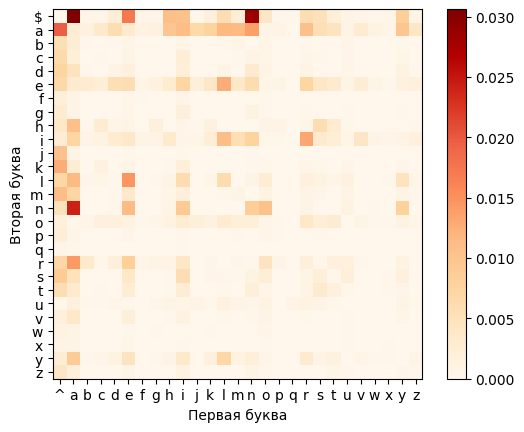

In [16]:
# Нарисуем heatmap
plt.imshow(df, cmap='OrRd', interpolation='nearest')
plt.xticks(range(len(df.columns)), df.columns)
plt.yticks(range(len(df.index)), df.index)
plt.colorbar()

plt.xlabel('Первая буква')
plt.ylabel('Вторая буква')

plt.show()

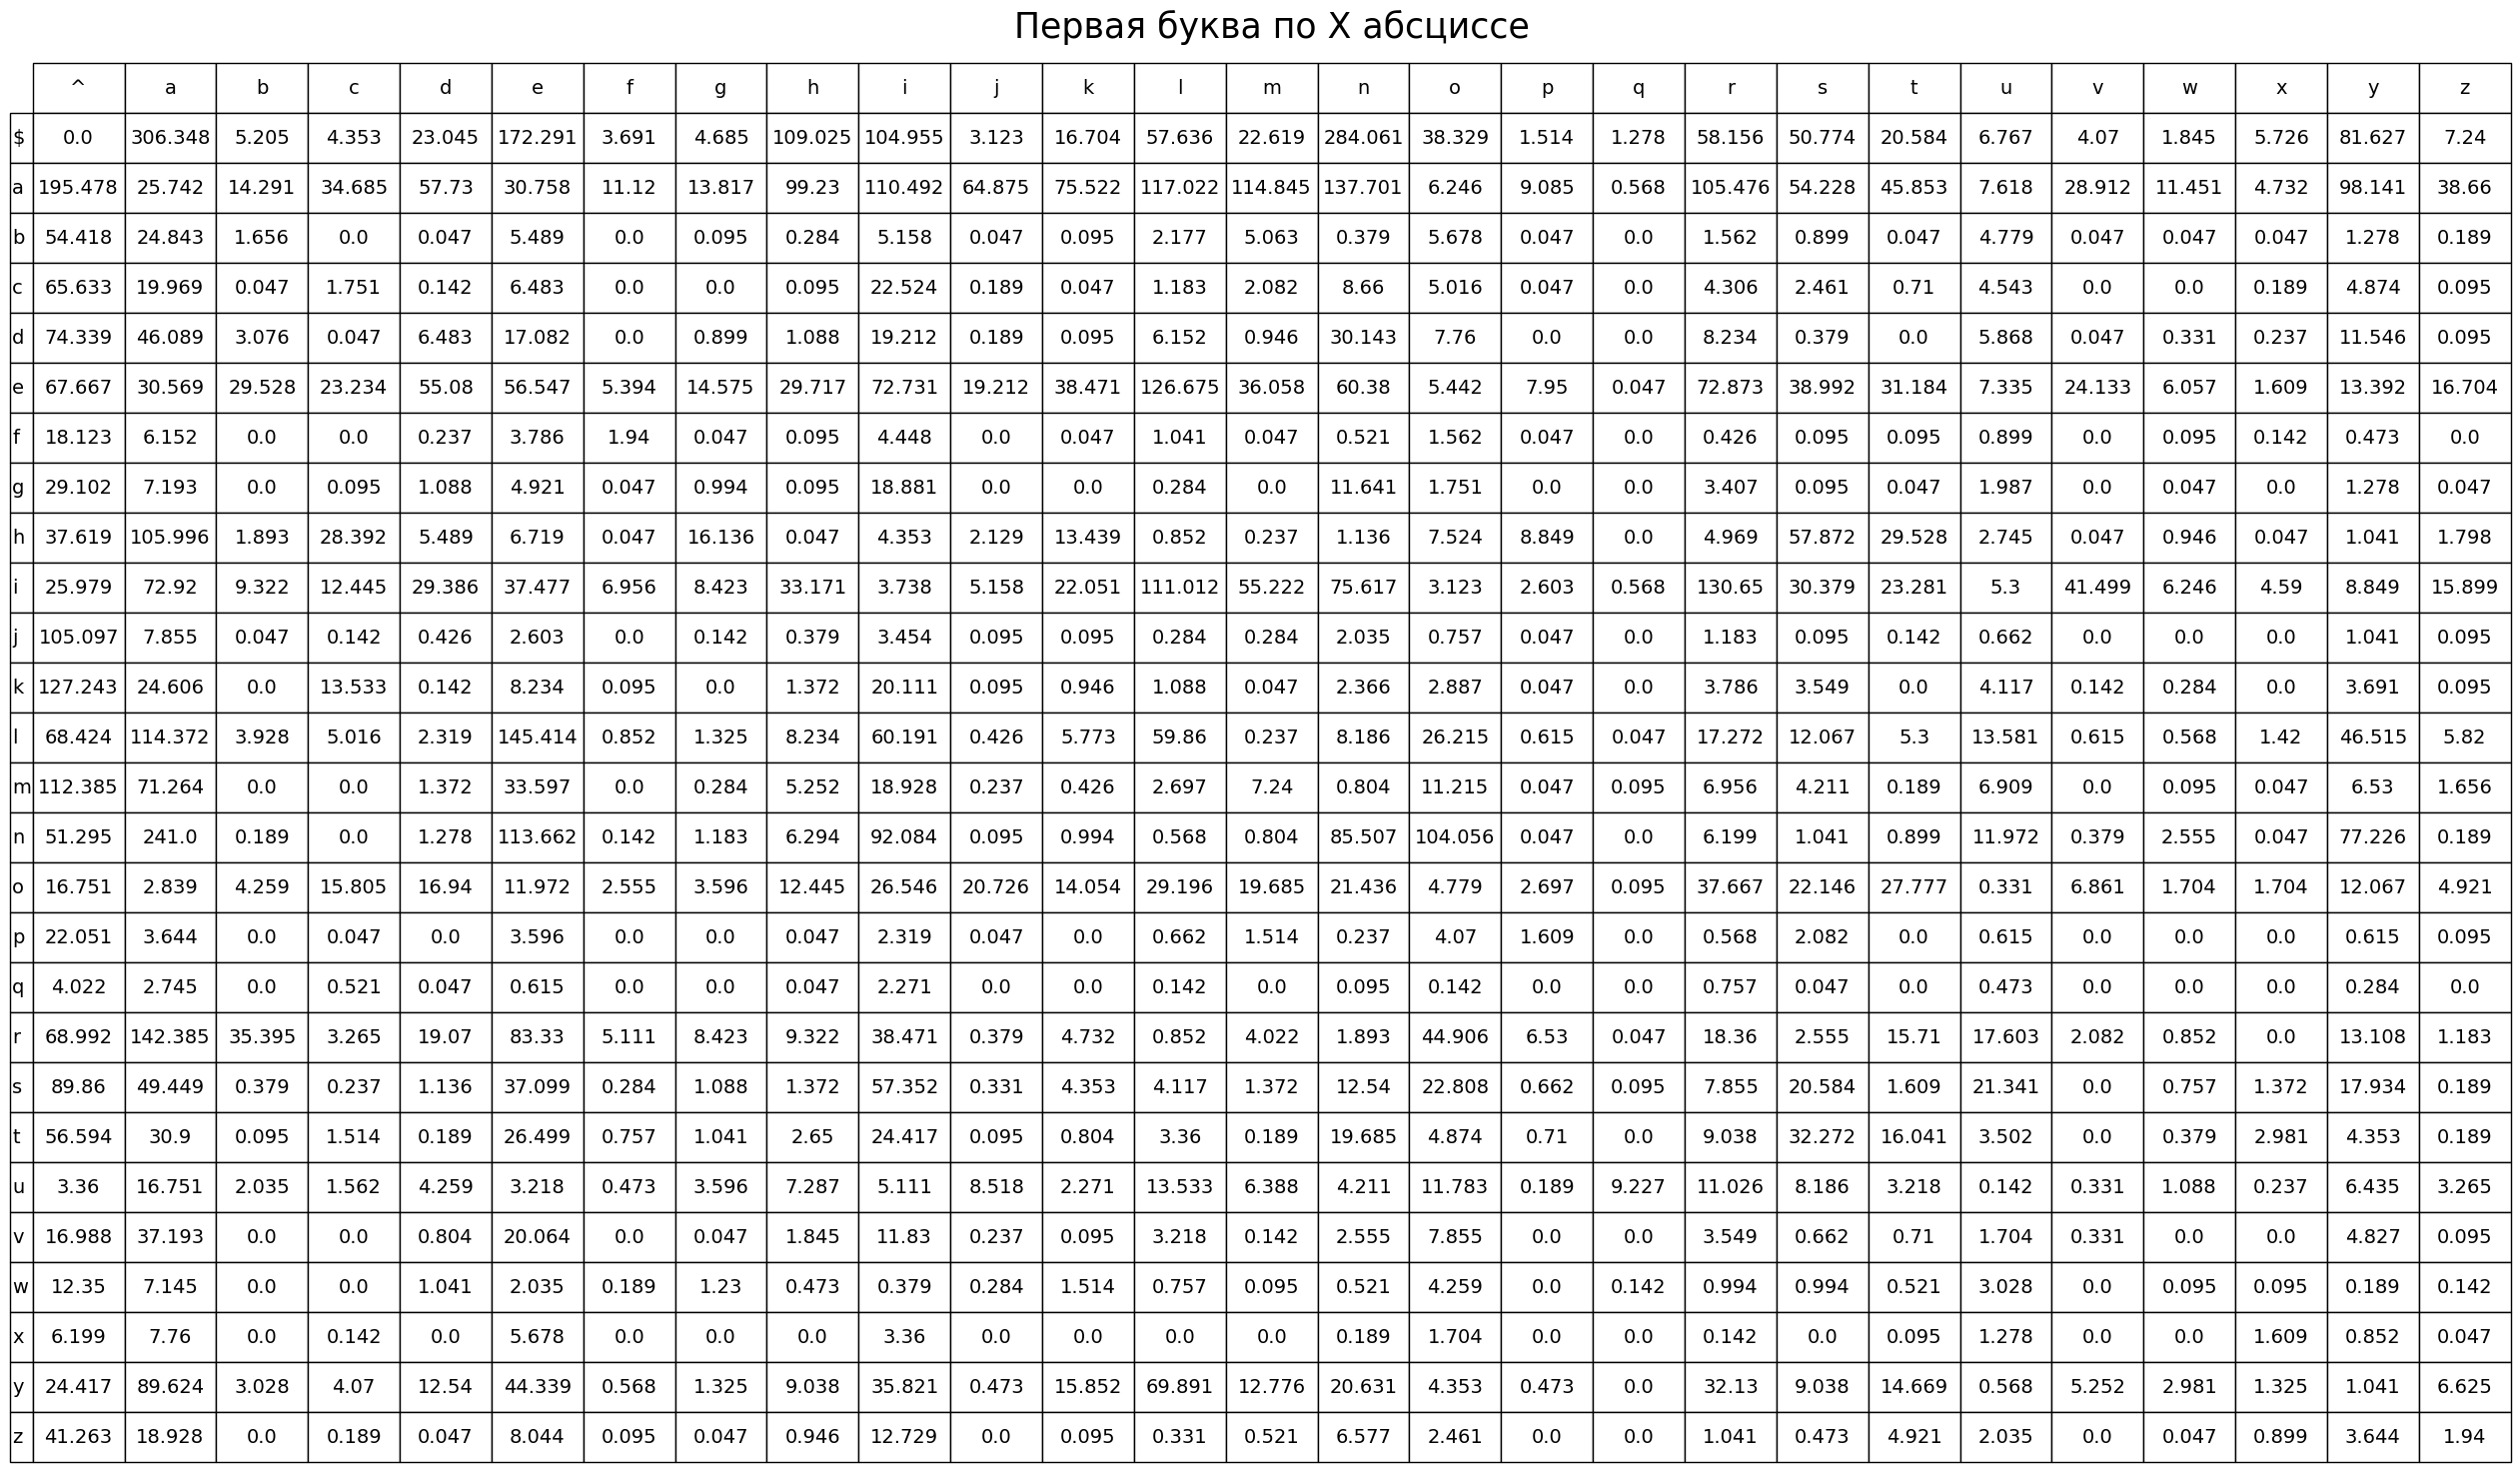

In [17]:
df = pd.DataFrame(columns=sorted(set([b[0] for b in bigram_probs.keys()])), 
                  index=sorted(set([b[1] for b in bigram_probs.keys()])))

for b, p in bigram_probs.items():
    df.loc[b[1], b[0]] = p * 10000  # Изменим масштаб для удобства чтения
df = df.astype(float).round(3)
df = df.fillna(0)

# Нарисуем таблицу
fig, ax = plt.subplots()
ax.set_axis_off()
table = ax.table(cellText=df.values, 
                 colLabels=df.columns, 
                 rowLabels=df.index, 
                 loc='center', 
                 cellLoc='center')

ax.set_title("Первая буква по X абсциссе", fontsize=25, y=2.5, pad=-10)

table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(5, 3)
plt.show()

In [18]:
# Сделаем ее более наглядной
import seaborn as sns

cm = sns.light_palette('green', as_cmap=True)

s = df.style.set_precision(3).background_gradient(cmap=cm, low=0, high=1, axis=0)
s

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/tmp/ipykernel_20/3786061090.py:6: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  s = df.style.set_precision(3).background_gradient(cmap=cm, low=0, high=1, axis=0)


,^,a,b,c,d,e,f,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,w,x,y,z
$,0.000,306.348,5.205,4.353,23.045,172.291,3.691,4.685,109.025,104.955,3.123,16.704,57.636,22.619,284.061,38.329,1.514,1.278,58.156,50.774,20.584,6.767,4.070,1.845,5.726,81.627,7.240
a,195.478,25.742,14.291,34.685,57.730,30.758,11.120,13.817,99.230,110.492,64.875,75.522,117.022,114.845,137.701,6.246,9.085,0.568,105.476,54.228,45.853,7.618,28.912,11.451,4.732,98.141,38.660
b,54.418,24.843,1.656,0.000,0.047,5.489,0.000,0.095,0.284,5.158,0.047,0.095,2.177,5.063,0.379,5.678,0.047,0.000,1.562,0.899,0.047,4.779,0.047,0.047,0.047,1.278,0.189
c,65.633,19.969,0.047,1.751,0.142,6.483,0.000,0.000,0.095,22.524,0.189,0.047,1.183,2.082,8.660,5.016,0.047,0.000,4.306,2.461,0.710,4.543,0.000,0.000,0.189,4.874,0.095
d,74.339,46.089,3.076,0.047,6.483,17.082,0.000,0.899,1.088,19.212,0.189,0.095,6.152,0.946,30.143,7.760,0.000,0.000,8.234,0.379,0.000,5.868,0.047,0.331,0.237,11.546,0.095
e,67.667,30.569,29.528,23.234,55.080,56.547,5.394,14.575,29.717,72.731,19.212,38.471,126.675,36.058,60.380,5.442,7.950,0.047,72.873,38.992,31.184,7.335,24.133,6.057,1.609,13.392,16.704
f,18.123,6.152,0.000,0.000,0.237,3.786,1.940,0.047,0.095,4.448,0.000,0.047,1.041,0.047,0.521,1.562,0.047,0.000,0.426,0.095,0.095,0.899,0.000,0.095,0.142,0.473,0.000
g,29.102,7.193,0.000,0.095,1.088,4.921,0.047,0.994,0.095,18.881,0.000,0.000,0.284,0.000,11.641,1.751,0.000,0.000,3.407,0.095,0.047,1.987,0.000,0.047,0.000,1.278,0.047
h,37.619,105.996,1.893,28.392,5.489,6.719,0.047,16.136,0.047,4.353,2.129,13.439,0.852,0.237,1.136,7.524,8.849,0.000,4.969,57.872,29.528,2.745,0.047,0.946,0.047,1.041,1.798
i,25.979,72.920,9.322,12.445,29.386,37.477,6.956,8.423,33.171,3.738,5.158,22.051,111.012,55.222,75.617,3.123,2.603,0.568,130.650,30.379,23.281,5.300,41.499,6.246,4.590,8.849,15.899


# Нейронная сеть с помощью TensorFlow keras

In [19]:
import string
from string import digits
import re
from sklearn.model_selection import train_test_split

In [20]:
# Создадим DataFrame, чтобы далее было удобнее работать 
df_names = pd.DataFrame({'name': names})

In [21]:
# Обработаем данные
df_names.name = df_names.name.apply(lambda x: x.lower())
df_names=pd.DataFrame({'name': df_names.name.unique()})
df_names.head()

,name
0,jaleesa
1,rhet
2,alexander
3,farhana
4,aranea


In [22]:
lenght_list=[]
for l in df_names.name:
    lenght_list.append(len(l))
max_len = np.max(lenght_list)
max_len

15

In [23]:
# Добавляем символ \t к имени, 
# чтобы отсрочить target на 1 отметку времени (timestamp)
df_names['name'] = df_names.name.apply(lambda x:'\t'+x)

In [24]:
# Добавляем символ \n, чтобы показать, что слово закончилось
df_names['target'] = df_names.name.apply(lambda x:x[1:len(x)]+'\n')

In [25]:
df_names.head()

,name,target
0,\tjaleesa,jaleesa\n
1,\trhet,rhet\n
2,\talexander,alexander\n
3,\tfarhana,farhana\n
4,\taranea,aranea\n


In [26]:
# Посмотрим, какие буквы встречаются
# (иногда могут быть не все)
all_chars=set()
for name in df_names.name:
    for c in name:
        if c not in all_chars:
            all_chars.add(c)
all_chars.add('\n')

# Получим индексы
char_to_ix = { ch:i for i,ch in enumerate(sorted(all_chars)) }
ix_to_char = { i:ch for i,ch in enumerate(sorted(all_chars)) }

In [27]:
# Подготовим input и output для работы с Keras
input_data = np.zeros((len(df_names.name), max_len+1, 28),dtype='float32')
output_data = np.zeros((len(df_names.name), max_len+1, 28),dtype='float32')

for i, x in enumerate(df_names.name):
    for t, ch in enumerate(x):
        input_data[i, t, char_to_ix[ch]] = 1.
for i, x in enumerate(df_names.target):
    for t, ch in enumerate(x):
        output_data[i,t, char_to_ix[ch]] = 1.

In [28]:
from keras.layers import Input, LSTM, Embedding, Dense
from keras.models import Model
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM, Dropout
from keras.callbacks import LambdaCallback
from keras.layers import TimeDistributed
from keras.optimizers import RMSprop
from keras.utils import plot_model

In [29]:
# Создаем нашу модель
model = Sequential()
model.add(LSTM(50, input_shape=(max_len+1, len(all_chars)), return_sequences=True))
model.add(TimeDistributed(Dense(len(all_chars))))
model.add(TimeDistributed(Activation('softmax')))
optimizer = RMSprop(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 16, 50)            15800     
                                                                 
 time_distributed (TimeDistr  (None, 16, 28)           1428      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 16, 28)           0         
 tributed)                                                       
                                                                 
Total params: 17,228
Trainable params: 17,228
Non-trainable params: 0
_________________________________________________________________


In [31]:
# Функция для генерации имен
def generate_name():
    stop=False
    ch='\t'
    counter=1
    target_seq = np.zeros((1, max_len+1, 28))
    target_seq[0, 0, char_to_ix[ch]] = 1.
    while stop == False and counter < 10:
        probs = model.predict(target_seq, verbose=0)[:,counter-1,:]
        c= np.random.choice(sorted(list(all_chars)), replace =False,p=probs.reshape(28))
        if c=='\n':
            stop=True
        else:
            ch=ch+c
            target_seq[0,counter , char_to_ix[c]] = 1.
            counter=counter+1
    return ch

In [32]:
def onend(epoch, logs):
    if epoch%2==0 and epoch !=0:
        print('----- Generating text after Epoch: %d' % epoch)
        for i in range(0,10):
            print(generate_name())

In [33]:
# Обучаем модель
print_callback = LambdaCallback(on_epoch_end=onend)
model.fit(input_data, output_data, batch_size=32,epochs=3, callbacks=[print_callback])

Epoch 1/3
922/922 [==============================] - 11s 10ms/step - loss: 0.9971
Epoch 2/3
922/922 [==============================] - 9s 10ms/step - loss: 0.9376
Epoch 3/3
921/922 [============================>.] - ETA: 0s - loss: 0.9204----- Generating text after Epoch: 2
	rquo
	sokiea
	aliyah
	coridaia
	aalegt
	derabel
	ameleifa
	mareleigh
	ruge
	nevichi
922/922 [==============================] - 14s 15ms/step - loss: 0.9204


In [34]:
# Сохраняем веса 
model.save_weights('name_generator_weights.h5')

# Загружаем
model.load_weights('name_generator_weights.h5')

In [35]:
# Пример генерации новых имен, используя полученные веса
for i in range(10):
    print(generate_name())

	rasabie
	erick
	bradin
	amilah
	xellyn
	jomeer
	nathariah
	chaan
	reyend
	ife


# Нейронная модель и оптимизация с помощью PyTorch

Первой по очереди я поставил keras модель, так как она менее громоздкая, ее легче кодить, число гиперпараметров и время обучения значительно меньше, чем модель с PyTorch

In [36]:
import os
import time
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import string
from collections import Counter

In [37]:
df_names = pd.DataFrame({'name': names})
df_names.name = df_names.name.apply(lambda x: x.lower() + '.')
df_names=pd.DataFrame({'name': df_names.name.unique()})

In [38]:
df_names.head()

,name
0,jaleesa.
1,rhet.
2,alexander.
3,farhana.
4,aranea.


In [39]:
print(df_names.shape)

(29494, 1)


In [40]:
chars = "." + string.ascii_lowercase
num_chars = len(chars)
print(chars)
print(num_chars)

.abcdefghijklmnopqrstuvwxyz
27


In [41]:
char_to_id = {c:i for i, c in enumerate(chars)}
id_to_char = {v:k for k, v in char_to_id.items()}
print(char_to_id)
print(id_to_char)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}
{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}


In [42]:
names_list = df_names['name'].tolist()
len(names_list)

29494

In [43]:
max_length = len(max(names, key=len))
max_length

15

In [44]:
# Для работы PyTorch модели с нашими данными 
class NamesDataset(Dataset):
    
    def __init__(self, names_list):
        self.names_list = names_list
        
    def __len__(self):
        return len(self.names_list)
    
    def __getitem__(self, idx):
        x_str = self.names_list[idx].ljust(max_length, ".")[:max_length]
        y_str = x_str[1:] + "."

        x = torch.zeros((max_length, num_chars))
        y = torch.zeros(max_length)
        for i, c in enumerate(x_str):
            x[i, char_to_id[c]] = 1
        for i, c in enumerate(y_str):
            y[i] = char_to_id[c]
      
        return x, y

In [45]:
trainset = NamesDataset(names_list)

In [46]:
# Гиперпараметр batch_size - это количество образцов, 
# которые обрабатываются перед тем, как модель обновляется. 
train_batch_size = 150 

In [47]:
train_loader = DataLoader(trainset, batch_size=train_batch_size, shuffle=True)
print(len(train_loader))

197


train_loader - это итератор, который содержит все обучающие данные, разбитые на батчи заданного размера.

iter(train_loader) создает объект-итератор, который будет поочередно возвращать батчи из train_loader при каждом вызове функции next().

In [48]:
train_iter = iter(train_loader)
X, Y = next(train_iter)
print(X.size(), Y.size())

torch.Size([150, 15, 27]) torch.Size([150, 15])


In [49]:
input_size = num_chars
hidden_size = 54 # Ещё один гиперпараметр
output_size = num_chars
num_layers = 1

In [50]:
# Наша PyTorch модель
class Model(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(Model, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                             num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(output_size, output_size)

    def forward(self, X, states):
        ht, ct = states
        batch_size = X.size(0)
        out, (ht, ct) = self.lstm1(X, (ht, ct))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out, (ht, ct) # out: Size([batch_size, max_length, num_chars])


In [51]:
model = Model(input_size=input_size, 
              hidden_size=hidden_size, 
              output_size=output_size, 
              num_layers=num_layers)

In [52]:
device = torch.device('cpu')

In [53]:
model = nn.DataParallel(model)
model = model.to(device)

In [54]:
ht = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)
ct = torch.zeros((num_layers, train_batch_size, hidden_size)).to(device)

In [55]:
# Гиперпараметры
lr = 0.005
step_size = len(train_loader) * 1
gamma = 0.95
print(step_size)

197


# Оптимизация через PyTorch

In [56]:
criterion = nn.CrossEntropyLoss(reduction='mean')
optimizer = optim.Adam(model.parameters(), lr=lr)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer=optimizer, 
                                         step_size=step_size, 
                                         gamma=gamma)

In [57]:
def generate_name(model, start='a', k=5):
    
    if len(start) >= max_length:
        return name
    
    with torch.no_grad():
        
        ht = torch.zeros((num_layers, 1, hidden_size)).to(device)
        ct = torch.zeros((num_layers, 1, hidden_size)).to(device)
        length = 0
        name = start

        for char in start:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            length += 1
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
        idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
        char = id_to_char[idx]
        
        while char != "." and length <= max_length-1:
            X = torch.zeros((1, 1, num_chars)) # [batch_size, timestep, num_chars]
            X[0, 0, char_to_id[char]] = 1
            out, (ht, ct) = model(X, (ht, ct))
            vals, idxs = torch.topk(out[0], k) # 0 -> first eg in a batch
            idx = np.random.choice(idxs.cpu().numpy()[0]) # 0 -> first...
            char = id_to_char[idx]
            length += 1
            name += char

        if name[-1] != ".":
            name += "."
    
    return name

In [58]:
def sampler(model, start='a', n=10, k=5, only_new=False):
    
    names = []
    cnt = 0
    while cnt <= n:
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1

        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

In [59]:
def random_sampler(model, start='a', n=10, k=5, only_new=False):

    names = []
    cnt = 0
    while cnt <= n:
        start = random.choice(string.ascii_lowercase)
        name = generate_name(model=model, start=start, k=k)
        if only_new: 
            if name not in names_list and name not in names:
                names.append(name)
                cnt += 1

        else:
            if name not in names:
                names.append(name)
                cnt += 1
    names = [name[:-1].title() for name in names]
    
    return names

In [60]:
epochs = 40
print_every_n_epochs = epochs // 10

# Обучение модели PyTorch

In [61]:
epoch_losses = []
epoch_lrs = []
iteration_losses = []
iteration_lrs = []

for epoch in tqdm(range(1, epochs+1), desc="Epochs"):
    epoch_loss = 0
    epoch_lr = 0

    for i, (X, Y) in tqdm(enumerate(train_loader, 1), total=len(train_loader), desc="Epoch-{}".format(epoch)):
    #for i, (X, Y) in enumerate(train_loader, 1):
        X, Y = X.to(device), Y.to(device)
        
        ht = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)
        ct = torch.zeros((num_layers, X.size(0), hidden_size)).to(device)

        optimizer.zero_grad()
        Y_pred_logits, (ht, ct) = model(X, (ht, ct))
        Y_pred_logits = Y_pred_logits.transpose(1, 2) # Check Loss Doc: [N, d1, C] -> [N, C, d1]

        loss = criterion(Y_pred_logits, Y.long())
        loss.backward(retain_graph=True)
        optimizer.step()
        lr_scheduler.step()
        
        iteration_losses.append(loss.item())
        iteration_lrs.append(lr_scheduler.get_lr()[0])
        epoch_loss += loss.item()
        epoch_lr += lr_scheduler.get_lr()[0]

    epoch_loss /= len(train_loader)
    epoch_lr /= len(train_loader)
    epoch_losses.append(epoch_loss)
    epoch_lrs.append(epoch_lr)
    
    if epoch % print_every_n_epochs == 0:    
        message = "Epoch:{}    Loss:{}    LR:{}".format(epoch, epoch_loss, epoch_lr)
        print(message)
        names = sampler(model, start='jo', n=10, k=10, only_new=False)
        print(names)

Epochs:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch-1:   0%|          | 0/197 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:389: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Epoch-2:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-3:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-4:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:4    Loss:0.8632638681358492    LR:0.004284753323286817
['Jooealytrehuhtu', 'Joundeamydtoere', 'Jolde', 'Joaryss', 'Jomoyliaragrtyg', 'Jotysiylnno', 'Joaimerhdetluos', 'Jodierncucuhuol', 'Jon', 'Joyiahdltynnot', 'Joyanehntiyue']


Epoch-5:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-6:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-7:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-8:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:8    Loss:0.822156722473009    LR:0.003489958361525366
['Jodriehse', 'Jocor', 'Jo', 'Jorontatotarahl', 'Joos', 'Joetyricoktcu', 'Jouayiagiilttit', 'Joodrekessossyo', 'Joohdllatsas', 'Joio', 'Jovorohodo']


Epoch-9:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-10:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-11:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-12:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:12    Loss:0.7991269666531364    LR:0.0028425928977021692
['Josadeligodhein', 'Joyussh', 'Johob', 'Joisyehsoh', 'Joonnytt', 'Jol', 'Jodamttinucuusc', 'Jovryukdugsl', 'Joronda', 'Joan', 'Jouromtrtiatoat']


Epoch-13:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-14:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-15:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-16:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:16    Loss:0.7832346080523457    LR:0.002315309681384037
['Jona', 'Joaethnartiukso', 'Jorretansatce', 'Joucidowonac', 'Joayan', 'Joe', 'Jouniy', 'Joasabohyss', 'Joiniccecyansut', 'Jodrlassyatderi', 'Joyi']


Epoch-17:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-18:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-19:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-20:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:20    Loss:0.7728276891151661    LR:0.0018858342061727925
['Joydtu', 'Jodlemyonekady', 'Joiily', 'Joyohobldw', 'Joeseamni', 'Joatlamtistouly', 'Joldusi', 'Joetemellah', 'Jo', 'Joimonniykosarr', 'Jostav']


Epoch-21:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-22:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-23:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-24:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:24    Loss:0.7647655545757507    LR:0.0015360237473915359
['Jold', 'Joartuoscsucwch', 'Joandiakamadob', 'Jolteckyncowcck', 'Jorcobyan', 'Joann', 'Joobhrymis', 'Jomaduumaedwuk', 'Joylyreosulaety', 'Joseldalt', 'Joshlcordwnnete']


Epoch-25:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-26:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-27:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-28:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:28    Loss:0.7593205758762843    LR:0.0012511009423988248
['Joan', 'Joruxtu', 'Jomialiigry', 'Johmv', 'Jomominesk', 'Joymostyehnnehd', 'Jostruxsuc', 'Joessya', 'Johdaidhd', 'Jonobakla', 'Jory']


Epoch-29:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-30:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-31:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-32:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:32    Loss:0.7551332830172505    LR:0.0010190295369647351
['Joo', 'Joyluinexon', 'Joluahedahitus', 'Jommenymyt', 'Jokesorya', 'Jontruxwdiguees', 'Johvpeen', 'Jolldnsc', 'Jouxtumonywio', 'Joha', 'Joysaesuase']


Epoch-33:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-34:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-35:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-36:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:36    Loss:0.7519440623709392    LR:0.0008300059267923802
['Joymssyoe', 'Jolanioneoesido', 'Jogbiel', 'Johe', 'Josen', 'Joertwdeekulosa', 'Jodhy', 'Joksiohnwn', 'Josfu', 'Joulthestuc', 'Jon']


Epoch-37:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-38:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-39:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch-40:   0%|          | 0/197 [00:00<?, ?it/s]

Epoch:40    Loss:0.7493400259066354    LR:0.0006760450149094397
['Joktousasa', 'Joy', 'Joilu', 'Jobyary', 'Joryan', 'Jovmmmemmaitinc', 'Joyley', 'Joi', 'Jombr', 'Jolcelyr', 'Joysteyo']


In [62]:
path = os.path.join("/kaggle", "working", "classifier.pth")
torch.save(model.state_dict(), path)

# Имена через PyTorch

In [63]:
path = os.path.join("/kaggle", "working", "classifier.pth")
model = Model(input_size=num_chars, hidden_size=hidden_size, output_size=output_size, num_layers=num_layers)
model = nn.DataParallel(model)
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [64]:
names = sampler(model, start='t', n=10, k=5, only_new=True)
print(names)

['Tdana', 'Tryamurec', 'Trrahnia', 'Tlanieele', 'Tsmymar', 'Tmeliarderechet', 'Tniyeta', 'Tllynste', 'Trneyash', 'Trranahde', 'Trren']


In [65]:
names = sampler(model, start='su', n=10, k=5, only_new=True)
print(names)

['Suhynna', 'Suainan', 'Suiyustawasu', 'Sueian', 'Suim', 'Sumeetha', 'Suhrah', 'Suat', 'Sueenessy', 'Suiak', 'Suuma']


**Наш случай**

In [66]:
names = random_sampler(model, n=10, k=5, only_new=True)
print(names)

['Iiki', 'Dllou', 'Blardoneesuseta', 'Eitahtom', 'Boddoel', 'Bny', 'Slaiand', 'Jndies', 'Kyshukennees', 'Oalyasrieselusa', 'Nraniaslousasun']


Заметим, что в итоге PyTorch модель дает результаты хуже, чем другие